In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
#from nst_utils import *
import numpy as np
import tensorflow as tf
import imageio

%matplotlib inline

In [2]:
# nst utils

class CONFIG:
    IMAGE_WIDTH = 496
    IMAGE_HEIGHT = 375
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.6
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    VGG_MODEL = 'pretrained-model/imagenet-vgg-verydeep-19.mat' # Pick the VGG 19-layer model by from the paper "Very Deep Convolutional Networks for Large-Scale Image Recognition".
    STYLE_IMAGE = 'images/stone_style.jpg' # Style image to use.
    CONTENT_IMAGE = 'images/content300.jpg' # Content image to use.
    OUTPUT_DIR = 'output/'
    
def load_vgg_model(path):
    vgg = scipy.io.loadmat(path)
    vgg_layers = vgg['layers']
    
    def _weights(layer, expected_layer_name):
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b

    def _relu(conv2d_layer):
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        #print(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filters=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    return graph

def generate_noise_image(content_image, noise_ratio = CONFIG.NOISE_RATIO):
    noise_image = np.random.uniform(-20, 20, (1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)).astype('float32')
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    return input_image

def reshape_and_normalize_image(image):
    image = np.reshape(image, ((1,) + image.shape))
    image = image - CONFIG.MEANS
    return image

def save_image(path, image):
    # Un-normalize the image so that it looks good
    image = image + CONFIG.MEANS
    # Clip and Save the image
    image = np.clip(image[0], 0, 255).astype('uint8')
    imageio.imsave(path, image)

[[[[123.68  116.779 103.939]]]]
------
(375, 496, 3)
[ 98.09055914 124.04123118 145.61974731]
<class 'numpy.float64'>
-----------
[69 70 65]
[227 202 176]
<class 'numpy.uint8'>


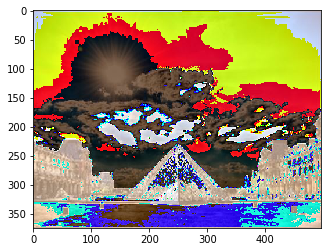

In [3]:
MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))
print(MEANS)

img = Image.open('l.jpg')
data = Image.Image.getdata(img)
print('------')
#print(img)
#print(img.size)
#imshow(img)

# croppen und resizen :)
im1 = img.crop((200,200,306,275)) 
im1 = im1.resize((200, 100)) 
#imshow(im1)

# alternative mit scipy zum öffnen/ nee mit imageio
s = imageio.imread('l.jpg')
#s = s.reshape((1,) + s.shape)
print(s.shape)
#imshow(s)

#print(s[0,0:10,:])

a = np.array(s).reshape(-1,3)
m = np.array(np.mean(a, axis=0))
print(m)
print(type(m[0]))
print('-----------')

print(a[0])
a = a - m
a= np.array(a, dtype=np.uint8)


print(a[0])
print(type(a[0,0]))

r = a.reshape(s.shape)
#print(r[0,0])
imshow(r)

In [4]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")
print(model)

{'input': <tf.Variable 'Variable:0' shape=(1, 375, 496, 3) dtype=float32, numpy=
array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
      

J_content = 6.7655935


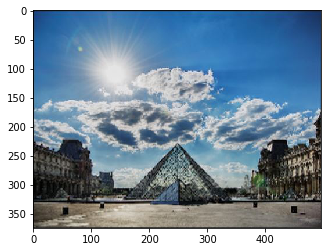

In [5]:
content_image = imageio.imread("l.jpg")
imshow(content_image)


def compute_content_cost(a_C, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_C_unrolled = tf.transpose(tf.reshape(a_C, [n_H*n_W, n_C]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G, [n_H*n_W, n_C]))
    J_content = (1/(4*n_H*n_W*n_C))*tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))
    return J_content

tf.compat.v1.reset_default_graph()

with tf.compat.v1.Session() as test:
    tf.compat.v1.set_random_seed(1)
    a_C = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

GA = [[ 6.422305 -4.429122 -2.096682]
 [-4.429122 19.465837 19.563871]
 [-2.096682 19.563871 20.686462]]
J_style_layer = 9.190278


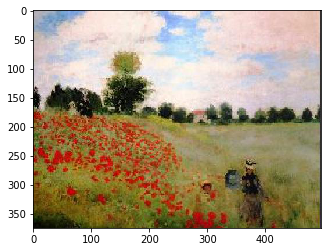

In [6]:
style_image = imageio.imread("m.jpg")
imshow(style_image)

def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))
    return GA

tf.compat.v1.reset_default_graph()
with tf.compat.v1.Session() as test:
    tf.compat.v1.set_random_seed(1)
    A = tf.random.normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = " + str(GA.eval()))
    
def compute_layer_style_cost(a_S, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_S = tf.transpose(tf.reshape(a_S, ([n_H*n_W, n_C])))
    a_G = tf.transpose(tf.reshape(a_G, ([n_H*n_W, n_C])))
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    J_style_layer = 1./(4*n_C**2 *(n_H*n_W)**2)*tf.reduce_sum(tf.pow((GS - GG), 2))
    return J_style_layer

tf.compat.v1.reset_default_graph()
with tf.compat.v1.Session() as test:
    tf.compat.v1.set_random_seed(1)
    a_S = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))
    
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

def compute_style_cost(model, STYLE_LAYERS):
    J_style = 0
    for layer_name, coeff in STYLE_LAYERS:
        out = model[layer_name]
        a_S = sess.run(out)
        a_G = out
        J_style_layer = compute_layer_style_cost(a_S, a_G)
        J_style += coeff * J_style_layer
    return J_style

In [7]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    J = alpha * J_content + beta*J_style
    return J

tf.compat.v1.reset_default_graph()
with tf.compat.v1.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.34667875478276


In [8]:
def model_nn(sess, input_image, num_iterations = 200):
    
    sess.run(tf.compat.v1.global_variables_initializer())
    sess.run(model["input"].assign(input_image))
    for i in range(num_iterations):
        sess.run(train_step)
        generated_image = sess.run(model['input'])
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            save_image("output/" + str(i) + ".png", generated_image)
    save_image('output/generated_image.jpg', generated_image)
    return generated_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
--------
--------
Iteration 0 :
total cost Jt= 6058379000.0
content cost Jc= 6708.4814
style cost = Js151457800.0


FileNotFoundError: The directory 'C:\\Users\\nikola.jovanovic\\Downloads\\output' does not exist

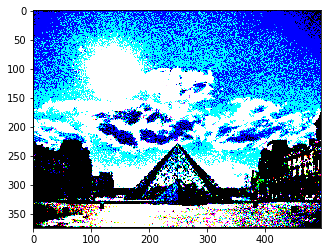

In [9]:
tf.compat.v1.reset_default_graph()
with tf.compat.v1.Session() as sess:
    #print(tf.__version__)

    content_image = imageio.imread("l.jpg")
    content_image = reshape_and_normalize_image(content_image)
    style_image = imageio.imread("m.jpg")
    style_image = reshape_and_normalize_image(style_image)
    generated_image = generate_noise_image(content_image)
    imshow(generated_image[0])

    model = load_vgg_model("imagenet-vgg-verydeep-19.mat")
    print('--------')
    sess.run(model['input'].assign(content_image))
    print('--------')
    out = model['conv4_2']
    #print(out)
    a_C = sess.run(out)
    a_G = out
    J_content = compute_content_cost(a_C, a_G)
    
    sess.run(model['input'].assign(style_image))
    J_style = compute_style_cost(model, STYLE_LAYERS)

    J = total_cost(J_content, J_style, alpha=10, beta= 40)
    
    optimizer = tf.compat.v1.train.AdamOptimizer(2.0)
    train_step = optimizer.minimize(J)
    
    #model_nn(sess, generated_image)
    input_image = generated_image
    num_iterations = 3
    sess.run(tf.compat.v1.global_variables_initializer())
    sess.run(model["input"].assign(input_image))
    for i in range(num_iterations):
        sess.run(train_step)
        generated_image = sess.run(model['input'])
        if i%1 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost Jt= " + str(Jt))
            print("content cost Jc= " + str(Jc))
            print("style cost = Js" + str(Js))
            save_image("output/" + str(i) + ".png", generated_image)
    save_image('output/generated_image.jpg', generated_image)

    #sess.close()